In [2]:
%matplotlib inline

In [3]:
import numpy as np
from netCDF4 import Dataset as ds
import matplotlib.pyplot as plt
from sympl import get_constant

Cpd = get_constant('heat_capacity_of_dry_air_at_constant_pressure', 'J/kg/degK')
Cvap = get_constant('heat_capacity_of_vapor_phase', 'J/kg/K')
g = get_constant('gravitational_acceleration', 'm/s^2')
Lv = get_constant('latent_heat_of_condensation', 'J/kg')

In [4]:
def plot_time_series(job_name):
    base_name = '/Users/haynesstephens1/uchi/research/climproj/climt_files'
    file_name = '{0}/{1}/{1}'.format(base_name, job_name)
    plot_base = '/Users/haynesstephens1/uchi/research/climproj/climproj/saved_plots'
    plot_name = '{0}/{1}/{1}_time_series.pdf'.format(plot_base, job_name)
    
    def loadData(file_name, var):
        return np.loadtxt('{0}_{1}.csv'.format(file_name, var), delimiter = ',')

    mid_levels = 28
    interface_levels = 29
    time_step_min = 10
    save_step = 100

    time_arr = loadData(file_name, 'time')
    time_arr = np.arange(time_arr.size)*save_step*time_step_min*60
    print(time_arr.size)
    time_adj = time_arr / (3600 * 24)
    time_title = 'Days'
    lh_flux = loadData(file_name, 'surface_upward_latent_heat_flux')
    sh_flux = loadData(file_name, 'surface_upward_sensible_heat_flux')
    precip = loadData(file_name, 'convective_precipitation_rate')
    tsurf = loadData(file_name, 'surface_temperature')
    co2_ppm = loadData(file_name, 'mole_fraction_of_carbon_dioxide_in_air')[0,0] * (10**6)
    
    upwelling_longwave_flux_in_air = loadData(file_name, 'upwelling_longwave_flux_in_air')
    upwelling_shortwave_flux_in_air = loadData(file_name, 'upwelling_shortwave_flux_in_air')
    downwelling_longwave_flux_in_air = loadData(file_name, 'downwelling_longwave_flux_in_air')
    downwelling_shortwave_flux_in_air = loadData(file_name, 'downwelling_shortwave_flux_in_air')

    net_flux = (upwelling_longwave_flux_in_air +
                upwelling_shortwave_flux_in_air -
                downwelling_longwave_flux_in_air -
                downwelling_shortwave_flux_in_air)

    net_flux_surface = net_flux[:, 0]
    net_flux_toa = net_flux[:,-1]
    
    air_pressure_on_interface_levels = loadData(file_name, 'air_pressure_on_interface_levels')
    air_pressure = loadData(file_name, 'air_pressure')
    air_temperature = loadData(file_name, 'air_temperature')

    fig, axes = plt.subplots(2,2, figsize=(10,10))

    ax0 = axes[0,0]
    ln1 = ax0.plot(net_flux[-1],
             air_pressure_on_interface_levels[-1], '-o',
             markersize=3, c='k', label='Flux')
    ax0.axes.invert_yaxis()
#     ax0.set_yscale('log')
    ax0.set_xlabel('Wm$^{-2}$')
    ax0.set_ylabel('Pa')
#     ax0.grid()

    ax0b = ax0.twiny()
    ln2 = ax0b.plot(air_temperature[-1],
             air_pressure[-1], '-o', markersize=3, c='r', label='Temp')
    ax0b.set_xlabel('K')
    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax0b.legend(lns, labs, loc=2)
#     ax0b.grid()
    

    
    ax1 = axes[0,1]
    ln1 = ax1.plot(time_adj, tsurf, '-', markersize=3, c='k', label = 'Tsurf')
#     ax1.set_title('Surface Temperature')
    ax1.set_xlabel(time_title)
    ax1.set_ylabel('K')
#     ax1.grid()
    
    ax1b = ax1.twinx()
    moist_enthalpy = loadData(file_name, 'moist_enthalpy')
    ln2 = ax1b.plot(time_adj, moist_enthalpy, '-', markersize=3, c='b', label = 'Moist Enth.')
    ax1b.set_ylabel('kJm$^{-2}$')
    
    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax1b.legend(lns, labs, loc=1)

    ax2 = axes[1, 0]
    ln1 = ax2.plot(time_adj, precip, '-', c='b', label = 'Precip', linewidth=2)
    ax2.set_title('Precipitation / Fluxes')
    ax2.set_xlabel(time_title)
    ax2.set_ylabel('mm/day')
#     ax2.grid()

    ax2b = ax2.twinx()
    ln2 = ax2b.plot(time_adj, lh_flux, '-.', c='y', label = 'LH Flux', linewidth=1)
    ax2b.set_ylabel('Wm$^{-2}$')
    
    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax2b.legend(lns, labs, loc=1)
#     ax2b.grid()

    ax3 = axes[1, 1]
    ax3.plot(time_adj, net_flux_surface, c = 'y', label='Rad')
    ax3.plot(time_adj, sh_flux, c = 'r', label = 'SH')
    ax3.plot(time_adj, lh_flux, c = 'b', label = 'LH')
    ax3.plot(time_adj, net_flux_toa, c='#d95f02', label='TOA')
    ax3.plot(time_adj, net_flux_surface + lh_flux + sh_flux, c='#7570b3', label = 'Surf')
    ax3.plot(time_adj, 
             (downwelling_longwave_flux_in_air + downwelling_shortwave_flux_in_air)[:,-1], '--',
            label = 'INC RAD')
    ax3.set_title('Fluxes (Up is +)')
    ax3.set_xlabel(time_title)
    ax3.set_ylabel('Wm$^{-2}$')
    # ax3.set_ylim(-50, 250)
    ax3.legend()
    ax3.grid()

    fig.suptitle('CO$_2$: {0} ppm'.format(co2_ppm//1), fontsize = 10,
                 bbox=dict(facecolor='none', edgecolor='green'),
                 x=0.53, y=0.5)
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()

In [5]:
### JUST CODE TO PLAY AROUND WITH THE ARRAYS
# job_name = 'test_a1_b1_c1'
# base_name = '/Users/haynesstephens1/uchi/research/climproj/climt_files'
# file_name = '{0}/{1}/{1}.nc'.format(base_name, job_name)
# nc = ds(file_name, 'r+', format='NETCDF4')
# i = 0
# dp = (nc['air_pressure_on_interface_levels'][i,:-1] - nc['air_pressure_on_interface_levels'][i,1:])
# C_tot = heat_capacity(nc['specific_humidity'][i])
# print(((C_tot * nc['air_temperature'][i] + Lv * nc['specific_humidity'][i]) * dp / g).sum())
# print(np.sum(((C_tot * nc['air_temperature'][i] + Lv * nc['specific_humidity'][i]) * dp / g)))

15769


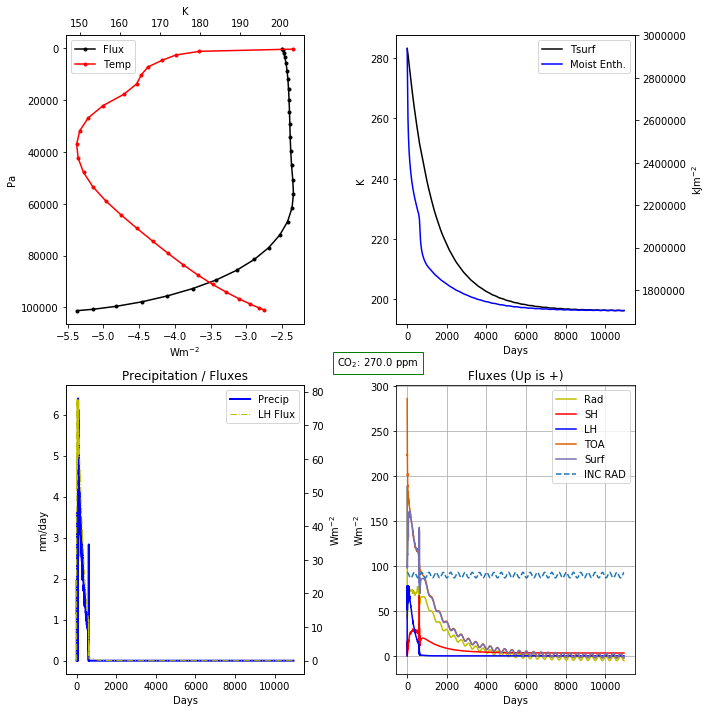

In [6]:
plot_time_series('test_a1_b1_c1')

15769


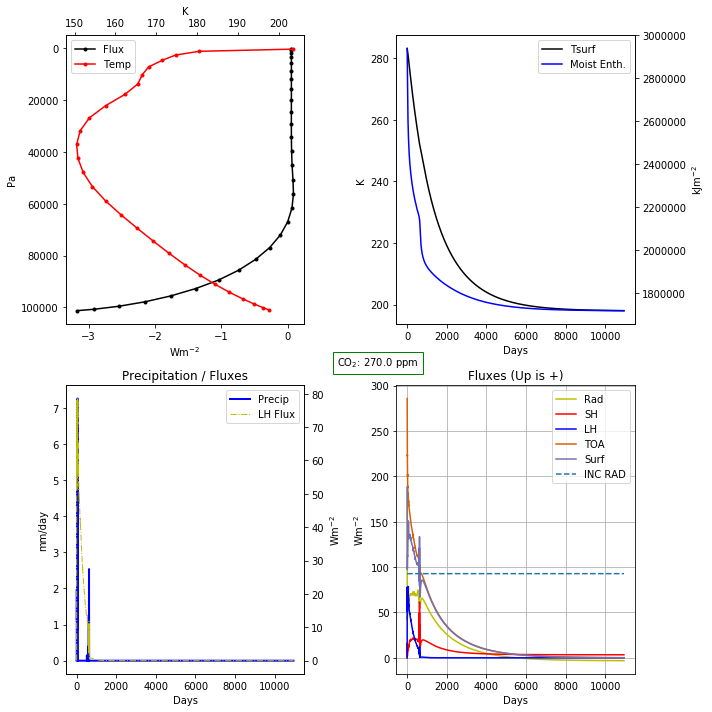

In [7]:
plot_time_series('test_a2_b1_c1')

15769


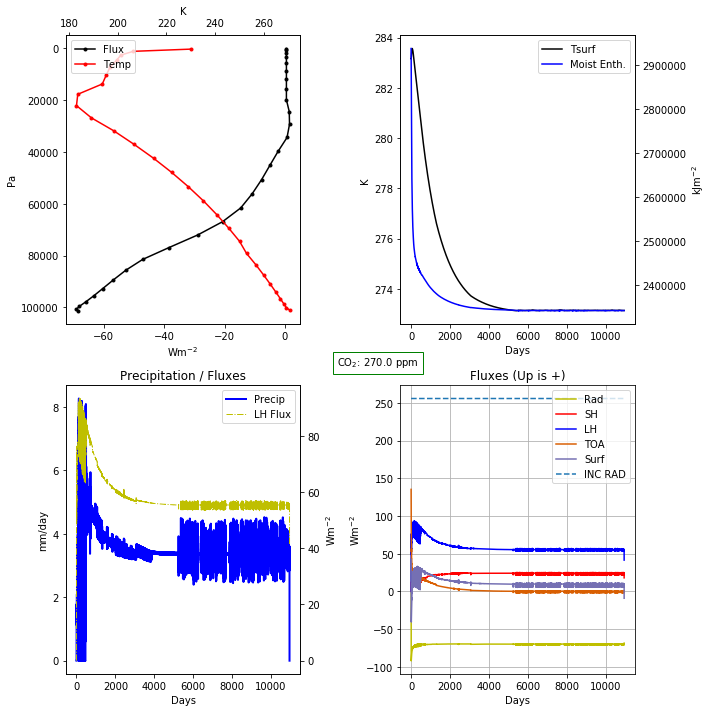

In [9]:
plot_time_series('test_a2_b1_c1_zen_32')

15769


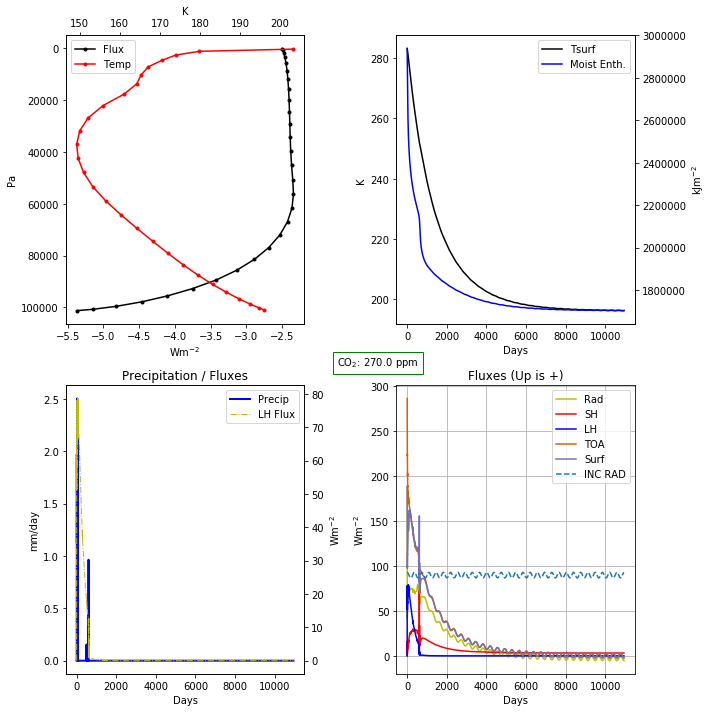

In [39]:
plot_time_series('test_a1_b2_c1')

15769


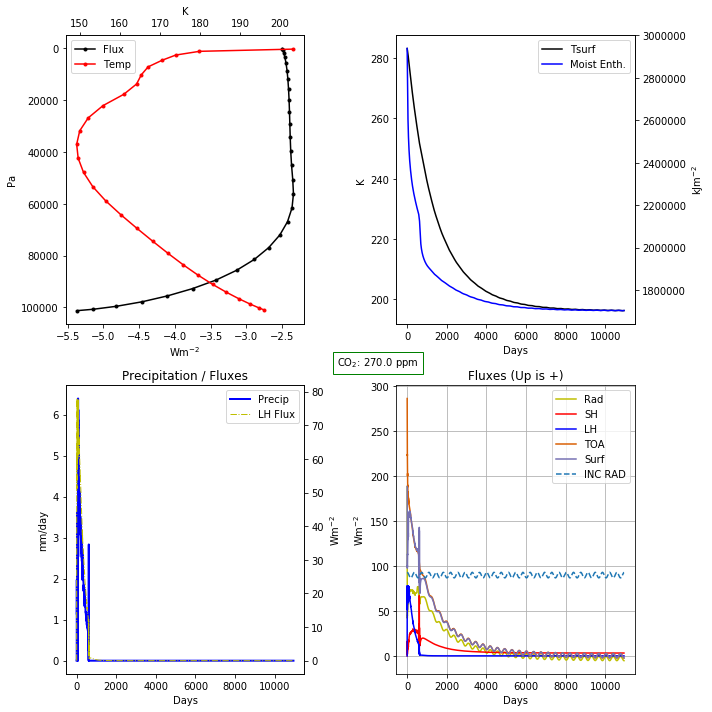

In [40]:
plot_time_series('test_a1_b1_c2')

15769


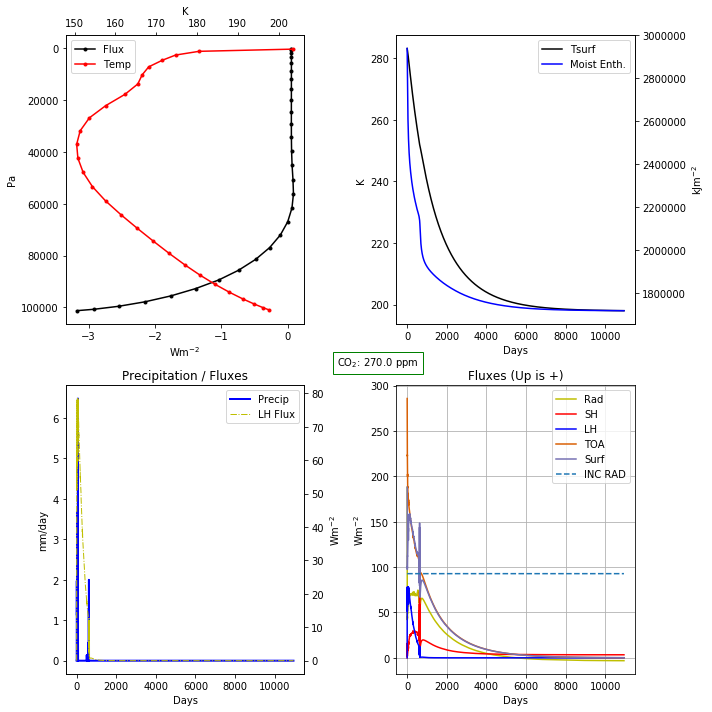

In [41]:
plot_time_series('test_a2_b2_c1')

15769


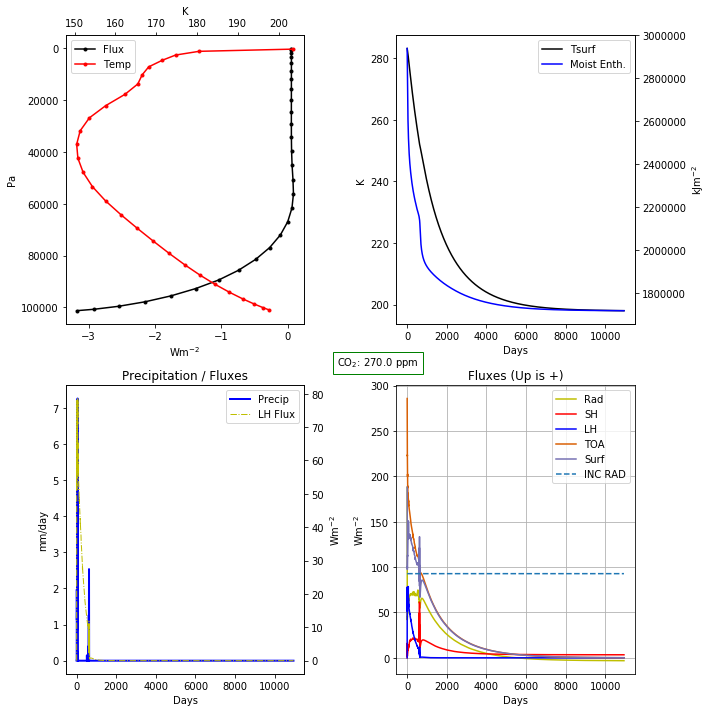

In [42]:
plot_time_series('test_a2_b1_c2')

15769


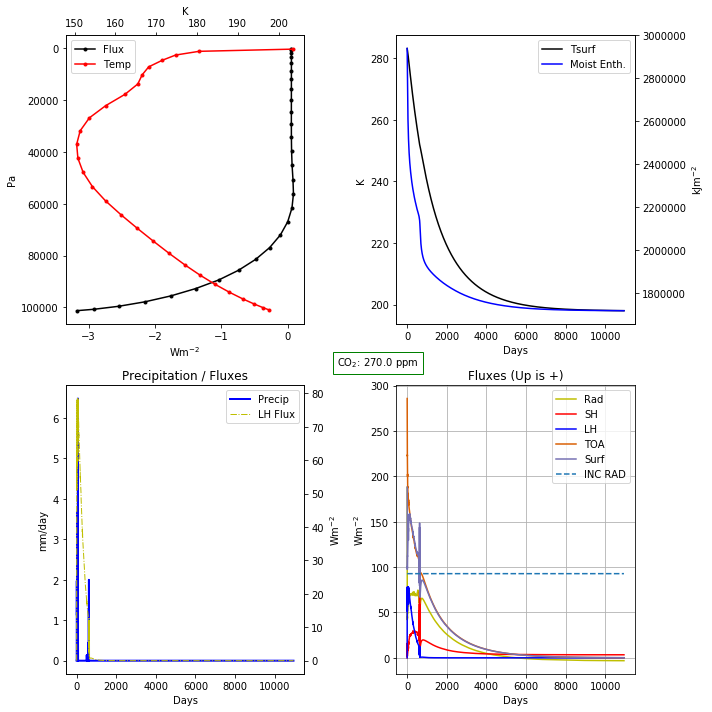

In [43]:
plot_time_series('test_a2_b2_c2')